In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import t
import math

season_stats = pd.read_csv('Seasons_Stats.csv')

players_df = season_stats[['Player', 'MP', 'PER', 'AST', 'Tm', 'Year']].dropna()
players_df = players_df[players_df.MP > 100]    # removing players who didn't play enough
TOT_mask = players_df.Tm == 'TOT'               # the sum of stats for a player that played for more than 1 team
players_df = players_df[~TOT_mask]
players_df['TbY'] = players_df.Year.astype(int).apply(lambda name: str(name)) + ' ' + players_df.Tm

print(players_df.sort_values(by='PER', ascending=False)[['Player', 'PER', 'AST', 'TbY']].head(20))

                  Player   PER    AST       TbY
1827   Wilt Chamberlain*  31.8  275.0  1963 SFW
8869     Michael Jordan*  31.7  485.0  1988 CHI
19611       LeBron James  31.7  587.0  2009 CLE
1706   Wilt Chamberlain*  31.7  192.0  1962 PHW
21933       LeBron James  31.6  551.0  2013 MIA
1962   Wilt Chamberlain*  31.6  403.0  1964 SFW
10212    Michael Jordan*  31.6  453.0  1991 CHI
23633      Stephen Curry  31.5  527.0  2016 GSW
9747     Michael Jordan*  31.2  519.0  1990 CHI
9297     Michael Jordan*  31.1  650.0  1989 CHI
20207       LeBron James  31.1  651.0  2010 CLE
13271    David Robinson*  31.0    8.0  1997 SAS
23012      Anthony Davis  30.8  149.0  2015 NOP
11731    David Robinson*  30.7  381.0  1994 SAS
21395       LeBron James  30.7  387.0  2012 MIA
24654  Russell Westbrook  30.6  840.0  2017 OKC
14292  Shaquille O'Neal*  30.6  114.0  1999 LAL
14806  Shaquille O'Neal*  30.6  299.0  2000 LAL
19877        Dwyane Wade  30.4  589.0  2009 MIA
16286      Tracy McGrady  30.3  411.0  2

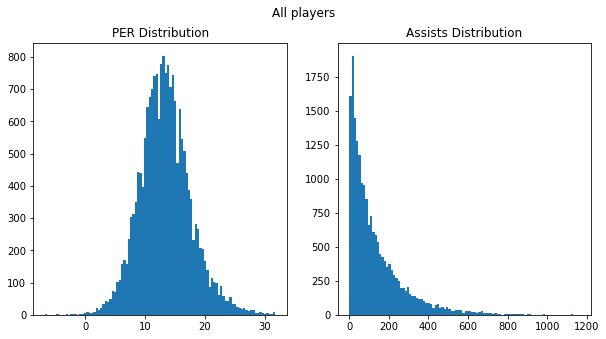

In [58]:
""" The Distribution of assists and efficiency measures of NBA players. """
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(players_df.PER, bins=100)
plt.title('PER Distribution')
plt.subplot(1, 2, 2)
plt.hist(players_df.AST, bins=100)
plt.title('Assists Distribution')
plt.suptitle('All players')
plt.show()

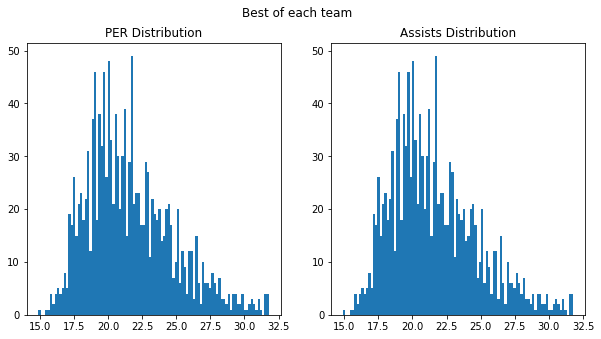

In [59]:
""" for each TbY find most affective individual player """
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
most_aff_player_by_team = players_df[['PER', 'TbY']].groupby(players_df.TbY).max()
plt.hist(most_aff_player_by_team.PER, bins=100)
plt.title('PER Distribution')
plt.subplot(1, 2, 2)
""" for each TbY find the player who passed the most assists """
most_ast_player_by_team = players_df[['AST', 'TbY']].groupby(players_df.TbY).max()
plt.hist(most_aff_player_by_team.PER, bins=100)
plt.title('Assists Distribution')
plt.suptitle('Best of each team')
plt.show()

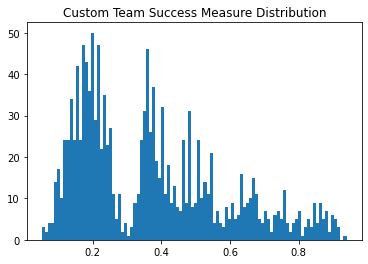

In [60]:
team_records = pd.read_csv('Team_Records.csv')
# team_records = team_records[team_records.Season > '1979']

def union_star(name):
    if name.endswith('*'):
        return name[:-1]
    return name

team_records['uNAME'] = team_records.Team.apply(lambda name: union_star(name))

team_names = pd.read_csv('Team_Names.csv')

def find_team(name):
    try:
        nn = team_names[team_names.Long == name].Short
        if nn.size == 1:
            return team_names[team_names.Long == name].Short.values[0]
        return 'NOT'
    except KeyError:
        return 'NOT'

team_records['NN'] = team_records.uNAME.apply(lambda name: find_team(name))
team_records['SS'] = team_records.Season.apply(
    lambda year: year[:2] + year[-2:] if year != '1999-00' else '2000')
team_records['TbY'] = team_records.SS + ' ' + team_records.NN

playoffs_weights_dic = {np.nan : 0, 'Won Finals' : 1, 'Lost Finals' : 0.8,
                        'Lost W. Conf. Finals' : 0.6, 'Lost E. Conf. Finals': 0.6,
                        'Lost W. Conf. Semis': 0.4, 'Lost E. Conf. Semis' : 0.4,
                        'Lost W. Conf. 1st Rnd.' : 0.2, 'Lost E. Conf. 1st Rnd.' : 0.2}

def score(s):
    try:
        return playoffs_weights_dic[s]
    except KeyError:
        return 'NOT'

team_records['PW'] = team_records.Playoffs.apply(score)
team_records = team_records[team_records.PW != 'NOT']
success = 0.5 * team_records['W/L%'] + 0.5 * team_records.PW
success.index = team_records.TbY

plt.hist(success, bins=100)
plt.title('Custom Team Success Measure Distribution')
plt.show()

In [61]:
trt_mask = team_records.TbY.apply(lambda ts: True if ts in most_aff_player_by_team.index else False)
team_records_eff = team_records[trt_mask]

trr_mask = pd.Series(most_aff_player_by_team.index, index=most_aff_player_by_team.index).apply(
    lambda ts: True if ts in team_records.TbY.values else False
)
most_aff_player_by_team = most_aff_player_by_team[trr_mask]
aff_suc = success[most_aff_player_by_team.index]

trt_mask = team_records.TbY.apply(lambda ts: True if ts in most_ast_player_by_team.index else False)
team_records_ast = team_records[trt_mask]

trr_mask = pd.Series(most_ast_player_by_team.index, index=most_ast_player_by_team.index).apply(
    lambda ts: True if ts in team_records.TbY.values else False
)
most_ast_player_by_team = most_ast_player_by_team[trr_mask]
ast_suc = success[most_ast_player_by_team.index]

In [62]:
per_p_value = stats.pearsonr(most_aff_player_by_team.PER, ast_suc)[0]
ast_p_value = stats.pearsonr(most_ast_player_by_team.AST, aff_suc)[0]
print(f'Efficiency      {per_p_value}\nAssists      {ast_p_value}')

Efficiency      0.4629870339087768
Assists      0.21605874135002318


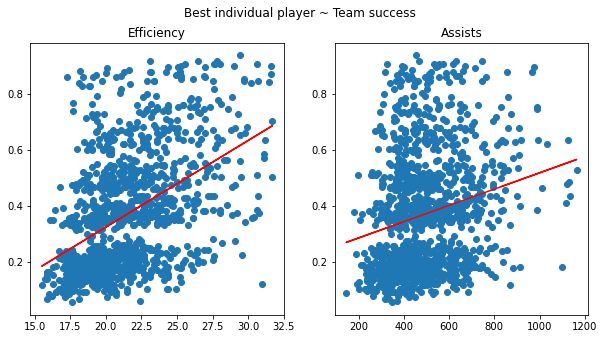

In [63]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(most_aff_player_by_team.PER, aff_suc)
m, b = np.polyfit(most_aff_player_by_team.PER.astype('float64'), aff_suc.astype('float64'), 1)
plt.plot(most_aff_player_by_team.PER, m * most_aff_player_by_team.PER + b, color="red")
plt.title('Efficiency')

plt.subplot(1, 2, 2)
plt.scatter(most_ast_player_by_team.AST, ast_suc)
m, b = np.polyfit(most_ast_player_by_team.AST.astype('float64'), ast_suc.astype('float64'), 1)
plt.plot(most_ast_player_by_team.AST, m * most_ast_player_by_team.AST + b, color="red")
plt.title('Assists')

plt.suptitle('Best individual player ~ Team success')
plt.show()